### Imports

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

!pip install lifelines # for survival analysis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.7/350.7 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 8.1 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=2ca628daafb39aa74ae57ad9df86644eb7149a935676a9bdb6e01f7f3b113f11
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


### Load data

In [2]:
%cd /content/drive/MyDrive/python_for_business_and_finance/survival_analysis_lung_cancer
df = pd.read_csv('lung.csv')
df.head()

/content/drive/MyDrive/python_for_business_and_finance/survival_analysis_lung_cancer


,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,3.0,306,2,74,1,1.0,90.0,100.0,1175.0,NaN
1,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0
2,3.0,1010,1,56,1,0.0,90.0,90.0,NaN,15.0
3,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0
4,1.0,883,2,60,1,0.0,100.0,90.0,NaN,0.0


### Data cleaning

In [5]:
df['status'] = df['status'].apply(lambda x: 0 if x == 1 else 1) # patient alive -> 0, dead -> 1
df.head(1)

,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,3.0,306,1,74,1,1.0,90.0,100.0,1175.0,NaN


### Kaplan-Meier estimator (non-parametric test to estimate the survival function i.e. probability of a person surviving)

The formula is: $S(t_i) = S(t_{i-1}) \big (1 - \frac{d_i}{n_i} \big )$, where

* $S(t_i)$ is the probability of survival at time $t_i$,
* $d_i$ is the number of events at time $t_i$,
* $n_i$ is the number of survivors at time $t_i$


In [9]:
from lifelines import KaplanMeierFitter

model = KaplanMeierFitter()
model.fit(durations = df['time'],
          event_observed = df['status'])

model.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,228,228
5.0,1,1,0,0,228
11.0,3,3,0,0,227
12.0,1,1,0,0,224
13.0,2,2,0,0,223
...,...,...,...,...,...
840.0,1,0,1,0,5
883.0,1,1,0,0,4
965.0,1,0,1,0,3


### Calculate for specific events

In [12]:
day_5 = model.event_table.iloc[1, :]
# print(day_5)
prob_survival_day_5 = 1 * (1- day_5['observed']/day_5['at_risk']) # according to above formula
print(prob_survival_day_5)

day_11 = model.event_table.iloc[2, :]
prob_survival_day_11 = prob_survival_day_5 * (1- day_11['observed']/day_11['at_risk'])
print(prob_survival_day_11)

0.9956140350877193
0.9824561403508771


### Visualization

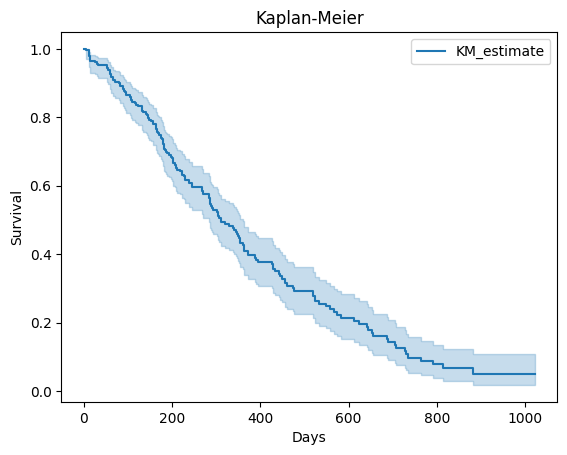

In [13]:
# Plot survival curve
model.plot()
plt.title('Kaplan-Meier')
plt.xlabel('Days')
plt.ylabel('Survival')
plt.show()

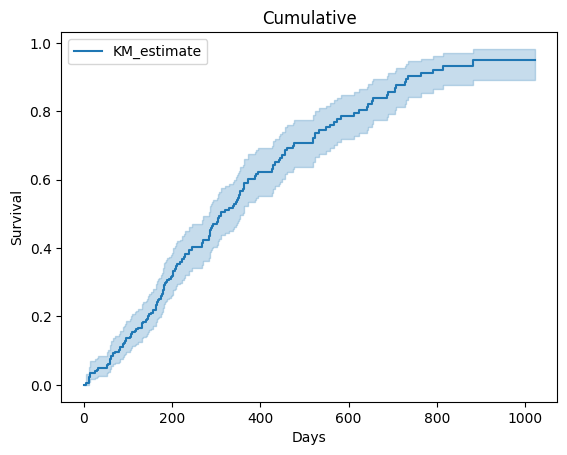

In [14]:
# Plot survival curve (cumulative)
model.plot_cumulative_density()
plt.title('Cumulative')
plt.xlabel('Days')
plt.ylabel('Survival')
plt.show()

### Log-rank test (testing statistical differences between groups)

In [15]:
# Create male vs female DataFrames
male = df[df['sex'] == 1]
female = df[df['sex'] == 2]

# male.head()

# Kaplan-Meier estimator per gender


,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,3.0,306,1,74,1,1.0,90.0,100.0,1175.0,NaN
1,3.0,455,1,68,1,0.0,90.0,90.0,1225.0,15.0
2,3.0,1010,0,56,1,0.0,90.0,90.0,NaN,15.0
3,5.0,210,1,57,1,1.0,90.0,60.0,1150.0,11.0
4,1.0,883,1,60,1,0.0,100.0,90.0,NaN,0.0


In [16]:
# Instantiate models for both sexes
model_male = KaplanMeierFitter()
model_female = KaplanMeierFitter()

# Model fitting
model_male.fit(durations = male['time'],
          event_observed = male['status'])

model_female.fit(durations = female['time'],
          event_observed = female['status'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 90 total observations, 37 right-censored observations>

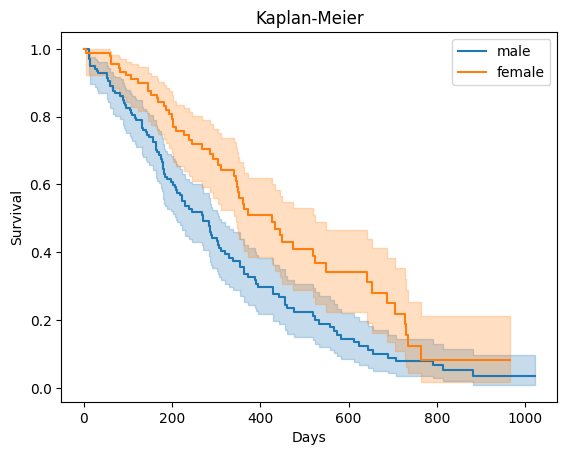

In [18]:
# Plot survival curve
model_male.plot(label = 'male')
model_female.plot(label = 'female')
plt.title('Kaplan-Meier')
plt.xlabel('Days')
plt.ylabel('Survival')
plt.legend()
plt.show()

In [19]:
# Log-rank test
from lifelines.statistics import logrank_test

logrank_test(durations_A = male['time'],
             durations_B = female['time'],
             event_observed_A = male['status'],
             event_observed_B = female['status'])

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          10.33 <0.005      9.57